---
title: Perceptron
author: Andrew Dean
date: '2025-03-23'
image: "perceptron.gif"
description: "Develops perceptron algorithm from scratch."
code-fold: true
execute:
    warning: false
    message: false
---

## Abstract

In this blog post, I dive into implementing the perceptron and run several experiments to explore its capabilities and limitations. The perceptron is designed to predict binary outcomes from data represented in a continuous, finite-dimensional feature space.  

My experiments demonstrate that the perceptron successfully converges to a solution that perfectly separates classes when the data is linearly separable. However, it fails to converge when the data is not linearly separable.  

I then extend this approach by implementing a more generalized version called the minibatch perceptron. This variation processes **k** observations per iteration instead of just one. I show that when **k=1**, the minibatch perceptron behaves identically to the standard perceptron. As **k** increases toward **n** (the total number of data points), the algorithm continues to find a decision boundary on linearly separable data. Interestingly, when **k=n**, the minibatch perceptron can converge on non-linearly separable data — though the resulting boundary won’t classify every point correctly.  

For the full implementation of both algorithms, check out **perceptron.py** and **minibatch_perceptron.py**.

As shown by Prof Chodrow, the perceptron algorithm follows an algorithmic process as follows:
Randomly select an initial decision boundary $w$, then repeat the following process until convergence:
1. Pick a random intenger $i$
2. Compute the score of the point $x_i$
3. Update the decision boundary $w$

In perceptron.py, I implement this process. I will only highlight my gradient function, as it turns the crucial math of the perceptron algo into code. My perceptron.grad() function is as follows:

```python
def grad(self, X, y):
    s = X@self.w
    return (s*y < 0)*X*y
```

Firstly, I take an input $X_i$ and calculate the dot product against the weight value $w$. Next, I use that result to calculate $[s_iy_i<0]y_iX_i$.


## Part A: Implementing Perceptron

In [129]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from matplotlib import pyplot as plt
from perceptron import Perceptron, PerceptronOptimizer
from perceptron_minibatch import MinibatchPerceptron, MinibatchPerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
%reload_ext autoreload

To check my perceptron implementation, I first create a set of data that is clearly linearly separable.

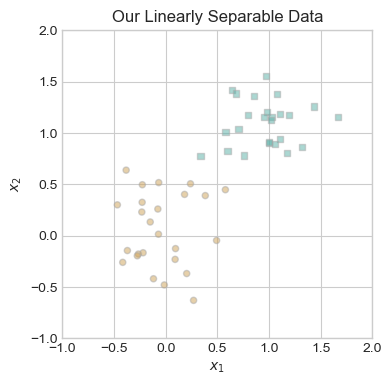

In [ ]:
def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    y = 2*y - 1

    return X, y

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

torch.manual_seed(42)

# create linearly separable data
X_ls, y_ls = perceptron_data(n_points = 50, noise = 0.3)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X_ls, y_ls, ax)
ax.set_title("Our Linearly Separable Data");

Next, I run my perceptron algo on this data, printing the loss at each iteration. Because our minimal training loop terminates, we know we converge to 0.

In [132]:
torch.manual_seed(42)

p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

loss_vec = []

while loss > 0: 
    loss = p.loss(X_ls, y_ls) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_ls, y_ls)

## Part B: Fitting and Evaluating Perceptron Models

### Part B.1: The Perceptron Algorithm on Linearly Separable Data

From our data above, I illustrate how the loss function changes between iterations of the minimal training loop.

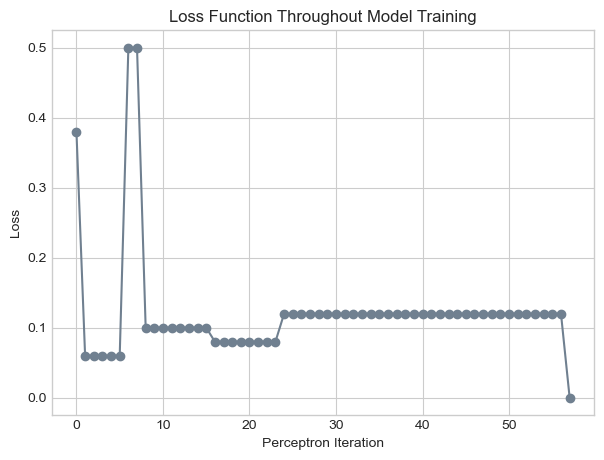

In [ ]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training")

Looking at how the loss changes with respect to the perceptron iteration, we can see that the loss is decreasing as the perceptron updates. This is expected, as the perceptron is designed to find a decision boundary that perfectly separates the data. The loss begins at 0.4, and eventually converges to 0 through almost 60 iterations. Through these iterations, though, the weight vector only changes 6 times. In all other iterations, the randomly selected point was correctly classified by the model at that stage.

To visualize how the decision boundary evolves during training, the figure below tracks changes to the weight vector. Each subplot shows a weight vector update, with dashed lines representing the previous boundary and solid lines showing the new one. The circled point in each subplot indicates the misclassified example that triggered the update.

Total updates needed: 23
Final loss: 0.000000


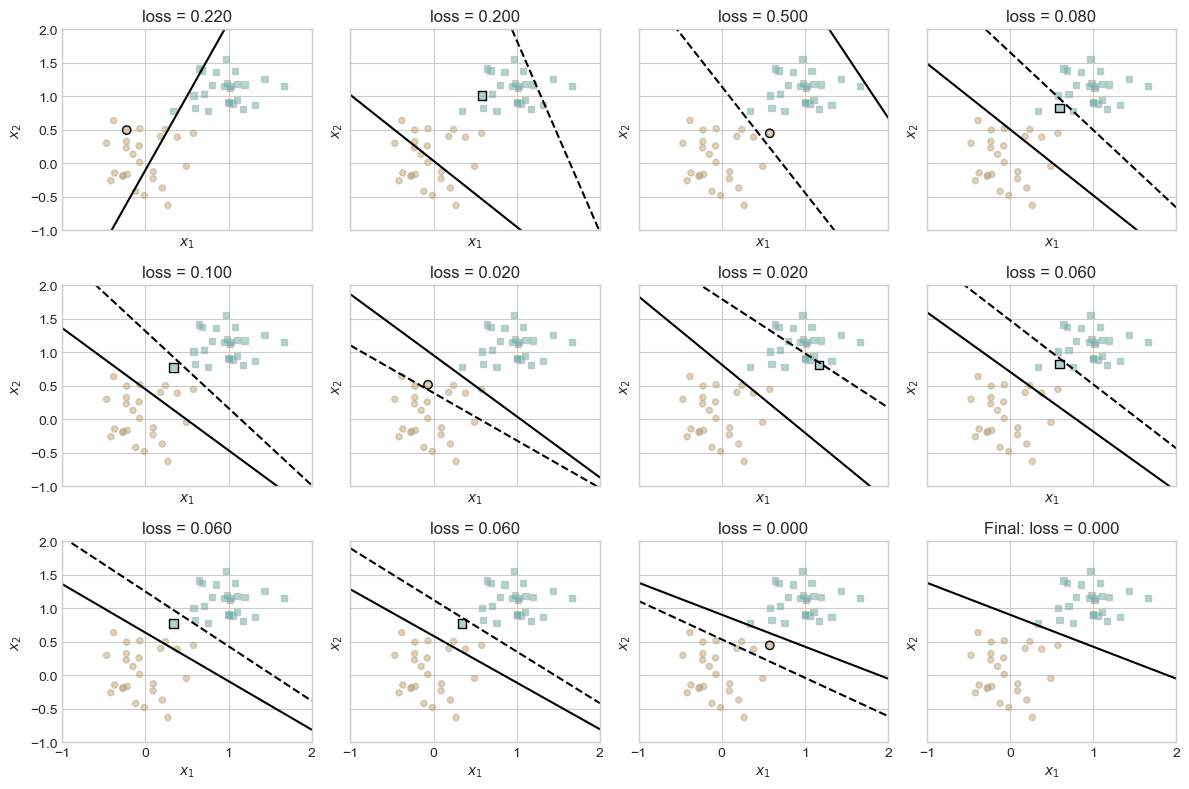

In [ ]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

torch.manual_seed(1234567)

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X_ls, y_ls)

plt.rcParams["figure.figsize"] = (12, 8)
fig, axarr = plt.subplots(3, 4, sharex=True, sharey=True)
markers = ["o", ","]
marker_map = {-1: 0, 1: 1}

current_ax = 0
loss = 1
loss_vec = []
max_plots = axarr.size

updates = []

while loss > 0:
    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step
    i, local_loss = opt.step(X_ls, y_ls)

    # if a change was made, record the update
    if local_loss > 0:
        loss = p.loss(X_ls, y_ls).item()
        loss_vec.append(loss)
        
        # Store this update
        updates.append({
            'old_w': old_w.clone(),
            'new_w': p.w.clone(),
            'point_idx': i,
            'loss': loss
        })

# If we have more updates than plots, select a representative subset
if len(updates) > max_plots - 1:  # Save one spot for final result
    # Choose evenly spaced updates, always including the first few and last one
    indices = np.linspace(0, len(updates)-1, max_plots-1, dtype=int)
    selected_updates = [updates[i] for i in indices]
else:
    selected_updates = updates

# Plot the selected updates
for idx, update in enumerate(selected_updates):
    if idx < max_plots:
        ax = axarr.ravel()[idx]
        plot_perceptron_data(X_ls, y_ls, ax)
        draw_line(update['old_w'], x_min=-1, x_max=2, ax=ax, color="black", linestyle="dashed")
        draw_line(update['new_w'], x_min=-1, x_max=2, ax=ax, color="black")
        i = update['point_idx']
        ax.scatter(X_ls[i,0], X_ls[i,1], color="black", facecolors="none", 
                  edgecolors="black", marker=markers[marker_map[y_ls[i].item()]])
        ax.set_title(f"loss = {update['loss']:.3f}")
        ax.set(xlim=(-1, 2), ylim=(-1, 2))

# Always show the final result in the last subplot
if current_ax < max_plots and len(updates) > 0:
    ax = axarr.ravel()[min(len(selected_updates), max_plots-1)]
    plot_perceptron_data(X_ls, y_ls, ax)
    draw_line(p.w, x_min=-1, x_max=2, ax=ax, color="black")
    ax.set_title(f"Final: loss = {loss:.3f}")
    ax.set(xlim=(-1, 2), ylim=(-1, 2))

plt.tight_layout()
print(f"Total updates needed: {len(updates)}")
print(f"Final loss: {loss:.6f}")

These figures show how the decision boundary evolves each time the model encounters a misclassified point. With each update, the boundary shifts to correct the current error, sometimes overcorrecting slightly. This creates a zigzag pattern of adjustments as the model alternates between fixing errors on opposite sides of the boundary, gradually converging to a position that correctly classifies all points.

### Part B.2: Seeing how the Model does on Non-Linearly Separable Data

The perceptron algorithm will not converge to a decision boundary on non-linearly separable data. To show this, let's first create a dataset that cannot be perfectly separated by a linear boundary. To do this, we'll use the same method as before but simply increase the noise level. As you'll see, it's clearly imposisble to separate the data with a single line.

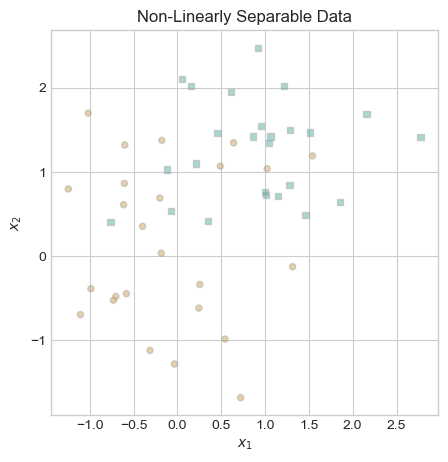

In [84]:
torch.manual_seed(42)

# create non-linearly separable data
X_nls, y_nls = perceptron_data(n_points = 50, noise = 0.8)

# plot non-linearly separable data
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
ax.set_title("Non-Linearly Separable Data");

Now that we have our non-linearly separable data, we can run the perceptron algorithm on it and see what happens. Since it will not converge, we can termiante the loop after a set number of iterations. We'll do this for 1000 iterations.

In [85]:
torch.manual_seed(42)

p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

loss_vec = []

iter = 0

while loss > 0: 
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_nls, y_nls) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_nls, y_nls)

    # update iter
    iter += 1

    # maxiter condition
    if iter >= 1000:
        break

We can create the same plot as before to visualize the loss changes:

Text(0.5, 1.0, 'Loss Function Throughout Model Training')

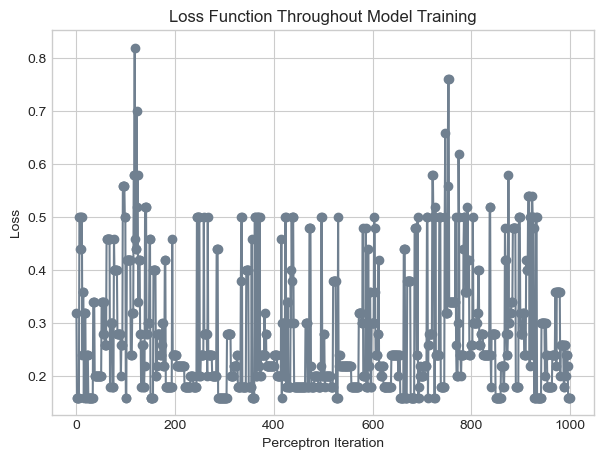

In [86]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training")

Looking at the figure above, it’s clear that my model fails to converge. The perceptron algorithm’s sensitivity to individual data points causes the loss to fluctuate dramatically throughout the process, swinging between values below of about 0.1 and over 0.7.  

For the linearly separable case, we previously examined each update to the weight vector. However, due to the sheer number of updates in this scenario, inspecting every change would be impractical. Instead, I present the decision boundary from the model’s final iteration:

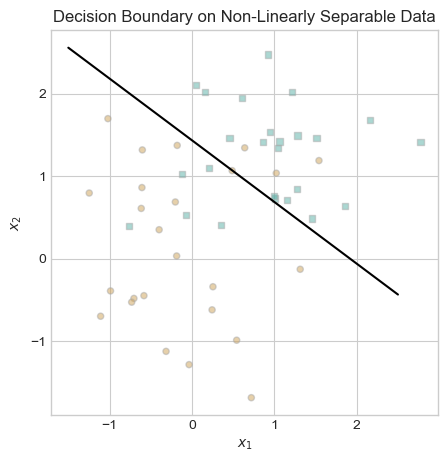

In [ ]:
# Plot final decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
draw_line(p.w, x_min = -1.5, x_max = 2.5, ax = ax, color = "black")
ax.set_title("Decision Boundary on Non-Linearly Separable Data");

This decision boundary doesn't look terrible. A majority of the blue points are above, while most of the orange points are below. However, there is definitely some misclassification, highlting perceptron's weekness on non-linearly separable data.

### Part B.3: On 5-Dimensions


To show that the perceptron algorithm works in any number of dimensions, I will generate a random dataset in 5 dimensions and run the perceptron algorithm on it.

In [100]:
torch.manual_seed(1234)

# create data
X_5d, y_5d = perceptron_data(n_points = 50, noise = 0.3, p_dims = 5)

p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
loss_vec = []

iter = 0

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    loss = p.loss(X_5d, y_5d) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_5d, y_5d)

    iter += 1
    if iter >= 1000:
        break

And let's take a look at the loss function:

Text(0.5, 1.0, 'Loss Function Throughout Model Training')

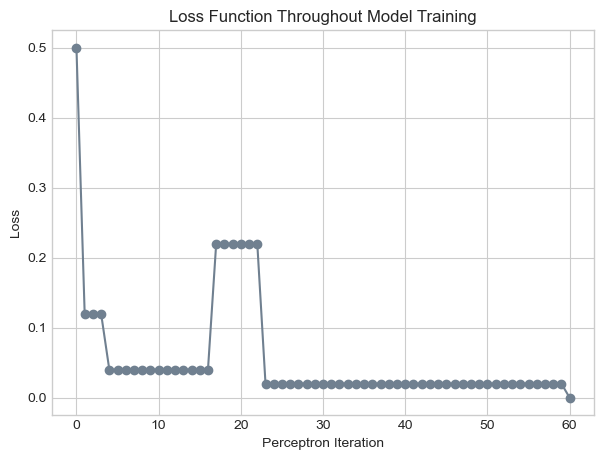

In [101]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training")

It looks that we terminate (achieve a loss of 0) meaning this 5d data is linearly separable. This is pretty cool that we can converge even in 5 dimensions.

## Part C: Minibatch Perceptron

The minibatch perceptron is a variation of the perceptron algorithm that processes **k** observations per iteration instead of just one. I will implement this algorithm and run several experiments to explore its capabilities and limitations.

### Part C.1: Experiment 1 (k=1)

First, I'll run the minibatch perceptron with $k=1$ and see how it performs.

In [103]:
def plot_loss(loss):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    plt.plot(loss, color = "slategrey")
    plt.scatter(torch.arange(len(loss)), loss, color = "slategrey", s=5)
    labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "loss")
    
    plt.title(f"Final loss: {loss[len(loss)-1]:.3f}")


In [104]:
torch.manual_seed(1234)

X, y = perceptron_data()

p = MinibatchPerceptron()
opt = MinibatchPerceptronOptimizer(p)
loss = 1.0

k = 1

loss_vec = []

n = X.size()[0]

while loss > 0:
    # random submatrix of feature matrix passed to PerceptronOptimizer.step()
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

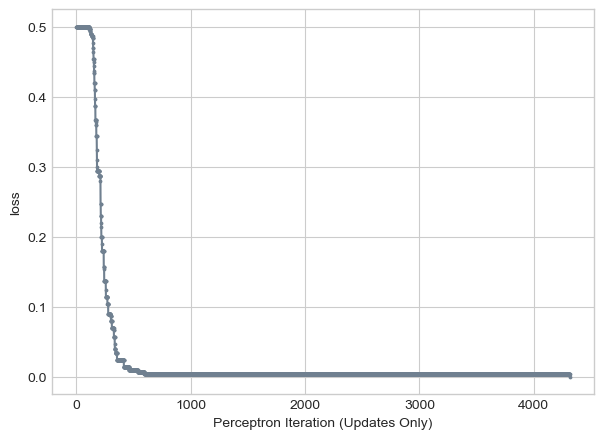

In [105]:
# plot the loss function
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s = 3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This looks like the minibatch perceptron is performing the similarly to the standard perceptron. We see a decreasing loss function, and the model converges to a loss of 0.

### Part C.2: Experiment 1 (k=10)

Let's see how the minibatch perceptron performs with $k=10$.

In [118]:
torch.manual_seed(1234)

X, y = perceptron_data()

p = MinibatchPerceptron()
opt = MinibatchPerceptronOptimizer(p)
loss = 1.0

# set k = 10
k = 10

loss_vec = []

n = X.size()[0]

while loss > 0:
    ix = torch.randperm(X.size(0))[:k] # random submatrix of feature matrix
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

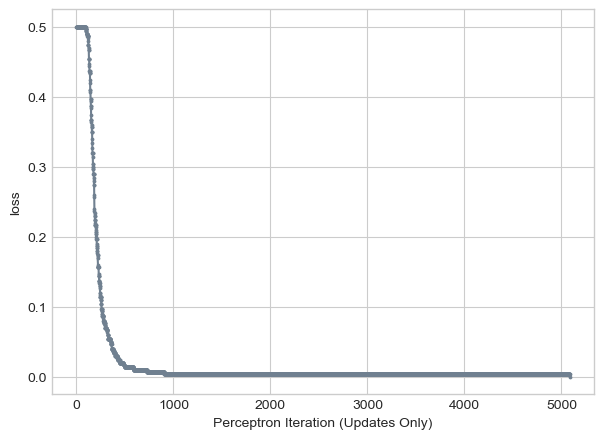

In [119]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s = 3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This looks similar to the previous experiment. The loss function is decreasing, and the model converges to a loss of 0.

### Part C.3: Experiment 1 (k=n)

In [126]:
torch.manual_seed(1234)

X, y = X_nls, y_nls

p = MinibatchPerceptron()
opt = MinibatchPerceptronOptimizer(p)
loss = 1.0

k = len(X)

loss_vec = []

n = X.size()[0]

for i in range (0,1000):
    # random submatrix of feature matrix passed to PerceptronOptimizer.step()
    ix = torch.randperm(X.size(0))[:k]
    x_i = X[ix,:]
    y_i = y[ix]
    
    opt.step(x_i, y_i)
    
    loss = p.loss(X, y).item()
    loss_vec.append(loss)

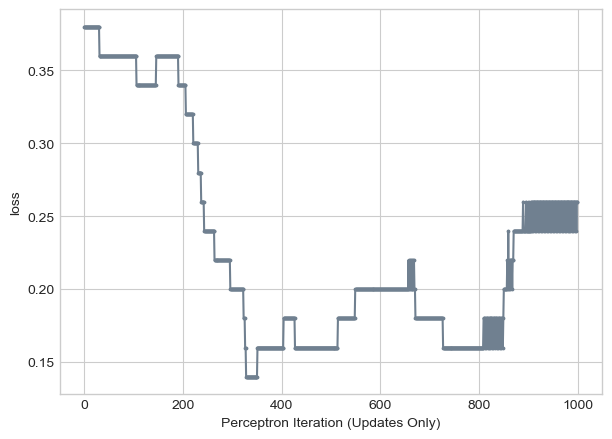

In [ ]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s = 3)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

When $k=n$ with data that is not linearly separable, the loss converges to about 0.25. And the resulting decision boundary:

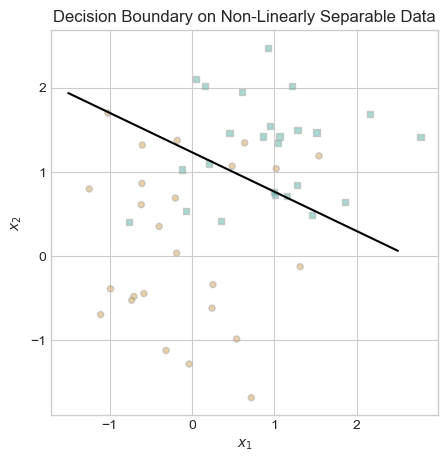

In [128]:
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
draw_line(p.w, x_min = -1.5, x_max = 2.5, ax = ax, color = "black")
ax.set_title("Decision Boundary on Non-Linearly Separable Data");

This line looks pretty good. The decision boundary is able to separate the data, but not perfectly.

## Part D: Runtime Analysis

The update in each iteration of the perceptron algorithm is computed as $X \times w$, representing the product between a single row of the matrix $X$ and the weight vector $w$. Each row of $X$ contains $p$ entries corresponding to the $p$ features, resulting in a time complexity of $O(p)$.

In my mini-batch perceptron algorithm, the dot product is computed for each data point in the batch of size $k$, leading to a runtime of $O(kp)$ per iteration.

## Conclusion

In this assignment, I explored the perceptron algorithm by implementing it from scratch. I demonstrated that the algorithm successfully converges on linearly separable data in any finite number of dimensions but fails to converge on non-linearly separable data. To address this limitation, I implemented the minibatch perceptron algorithm. I observed that when $k = 1$, the minibatch perceptron behaves similarly to the standard perceptron. As $k$ increases, the algorithm continues to find decision boundaries for linearly separable data. Notably, when $k = n$ (where $n$ is the total number of data points), the algorithm can converge to an imperfect solution even on non-linearly separable data. This assignment gave me valuable experience in implementing my first machine learning model from scratch and analyzing its performance and limitations.